# Hybrid sorting

In this project, you will experiment with two sorting algorithms, compare their running time, and build a hybrid algorithm based on your experimental results.

If you want to use the code for running time experiments that I have put in this Notebook, you will need to import these modules:

In [ ]:

import numpy as np
import numpy.random as ran
from timeit import default_timer as timer

If you want to use my plotting code, you also need to include these models. If you have installed `miniconda` and not the full `conda` distribution, you might not have these modules. If that is the case, you can open a terminal and install them with this commands:

```sh
conda install pandas seaborn
```

You need to do this before you can evaluate the cell.

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline

## Quicksort

The algorithm *quick sort* is a divide and conquer sorting algorithm that has an expected running time of $O(n\log n)$. The *expected* qualifier is there because the running time analysis is based on probabilistic assumptions. We will get to this in a bit. It is called *quick* because it uses very few operations compared to other divide-and-conquer sorting algorithms.

The algorithm works like this. If you want to sort an array (e.g. a Python list) from index $i$ to index $j$, then you pick a random element in this interval. Let us call it $p$ for *pivot*. We partition the items in `x[i:j]` (in place) such that the leading elements in the partitioning are all less than or equal to the pivot and all elements in the last part of the array are larger than the pivot. Since the pivot is selected from the elements in `x[i:j]`, the first part of the partitioning cannot be empty; the last part can. Let us call the last index in the first part $k$ and make the additional requirement that `x[k]` equals the pivot.

![](partitioning.png)

This partitioning can be used to break down the search problem into two sub-parts. Since all the elements in the first part are less than all items in the second part, we can sort the two segments independently. We can do this recursively. By requiring that the pivot is placed at `x[k],` we can leave that element out of the recursion which will guarantee that the recursive function never recurses on the same sequence as it was called with.

The algorithm looks like this:

In [ ]:
def qsort_rec(x, i, j):
    if j - i <= 1: 
        # x[i:j] is [] or [e] -> so already sorted
        return
    k = partition(x, i, j)
#    print(x)
    qsort_rec(x, i, k-1)
    qsort_rec(x, k, j)

def qsort(x):
    qsort_rec(x, 0, len(x))

In [ ]:
n=4

x = list(ran.randint(10, size = n))

print(x)

qsort(x)

print(x)

The runtime analysis goes like this: If the pivot is chosen at random then the two parts of the partition are expected to be roughly equal in length. If we can handle the partitioning in linear time the runtime recurrence is then

$$T(n) = 2T(n/2) + O(n)$$

which we know is $O(n\log n)$. If we are unlucky in our selection of pivots, one of the partitions will be empty and the other contain $n-1$ elements (we eliminate `x[k]` in each recursion but no more). In that case we get the recurrence $T(n) = T(n-1) + O(n)$ which is $O(n^2)$. If we pick the pivot at random, we can still be unlucky but only with low probability.

Sampling a random pivot from the sequence is potentially slow, so we often just pick the first element. This can hurt the running time substantially if the input is already close to sorted; then the first element is likely to be among the smallest values in the range and the partitioning will be uneven. Another approach is to pick a few elements at fixed indices, e.g. the first, the last and the middle element, and then pick the median of this. On pathological input, this can give us a quadratic running time, but it is less likely.

If you like the median of three points, you might find this function useful:

In [ ]:
def median3(x, y, z):
    if min(y,z) <= x <= max(y,z): return x
    if min(x,z) <= y <= max(x,z): return y
    if min(x,y) <= z <= max(x,y): return z

WIP Partition alternative.

def partition_median(x,i,j):
    j-=1
    k = median3(x[i],x[j], x[j//2])
    print(k)
    while i != j:
        print(i,j)
        if x[i] == x[j]:
            i+=1
        elif x[i] > x[j] and x[i] >= k:
            x[i], x[j] = x[j], x[i]
            j-=1
        elif x[i] < x[j] and x[i] <= k:
            j-=1
        else: 
            i+=1
        print(x)

    
    print(k)
    return k


n=12

x = list(ran.randint(10, size = n))

print(x)

partition_median(x,0,len(x))

print(x)

**Exercise:** Implement the partitioning.

In [ ]:
def partition(x, i, j):
    """
    Let pivot = x[i]. This function will
    arrange x[i:j] into x'[i:k] + x'[k:j] such that
    x'[h] <= pivot for h = i ... k and
    x'[k] == pivot and
    x'[h] > pivot for h = k + 1 ... j
    and then returns this k
    """
    lower = []
    higher = []
    p=x[i]
    for n in x[i+1:j]:
        if n <= p:
            lower.append(n)
#            print(lower)
        else:
            higher.append(n)
#            print(higher)
    lower.append(p)
    x[i:j] = lower + higher
#    print(p,lower,higher,x, len(lower)+i)
    return len(lower)+i
    pass


To test how fast the `qsort` function is, we can compare it to the `insertion_sort` algorithm

In [ ]:
def insertion_sort(x):
    for i in range(1,len(x)):
        j = i
        while j > 0 and x[j-1] > x[j]:
            x[j-1], x[j] = x[j], x[j-1]
            j -= 1

You can use this function to collect time information.

In [365]:
def time_algorithms(ns, sort_algs):
    """
    Run each sort-algorithm implemented in functions and
    provided in `sort_algs` on random lists of length
    n for each n in `ns`.
    
    Returns a Pandas DataFrame that we can use for plotting
    or extracting summary data.
    """
    algs, ns_, times = [], [], []
    for n in ns:
        x = list(ran.randint(10, size = n))
        for alg in sort_algs:
            x_copy = x[:]
            start = timer()
            alg(x_copy)
            end = timer()
            
            algs.append(alg.__name__)
            ns_.append(n)
            times.append(end - start)
            #print(alg,n,x)
            assert sorted(x) == x_copy
    
    return pd.DataFrame({'alg': algs, 'n': ns_, 'time': times})

The code below runs the `qsort` and the `insertion_sort` on a range of sizes, collected in the list `ns`. For each combination of sort-function and `n` we replicate the time measurements `no_reps` times. YOu can modify the setup to your heart's content.

In [ ]:
algs = [qsort, insertion_sort]
no_reps = 5
min_n, max_n = 1, 200
ns = []
for n in range(min_n, max_n):
    ns.extend([n] * no_reps)
    print(x)
time_measures = time_algorithms(ns, algs)

Once we have collected the time measurements we can plot it using the code below.

In [ ]:
g = sns.lmplot(x = 'n', y = 'time', hue = 'alg', lowess = True,
           x_jitter = 0.1, markers='.',
           data = time_measures)
g.set(ylim = (0, max(time_measures['time'])))

## Tail-recursion optimization

You call `qsort` twice in the implementation above. 

**Exercise:** Make a modified version that uses the tail-recursion optimization.
**Exercise:** Compare its running time with the one that doesn't.

In [1]:

def qsort_rec(x, i, j):
    if j - i <= 1: 
        # x[i:j] is [] or [e] -> so already sorted
        return
    k = partition(x, i, j)
    qsort_rec(x, i, k-1)
    qsort_rec(x, k, j)

def qsort(x):
    qsort_rec(x, 0, len(x))
    
def qsort_shit(x, i, j):
# works with almost the same running time and does both sides
    while i < j:
        k = partition(x, i, j)
        if k < (j - i) / 2:
            qsort_shit(x, i, k - 1)
            i += 1
        else:
            qsort_shit(x, k + 1, j)
            j = k - 1


def qsort_rec_tail_optimized(x, i, j):
#Doesn't work, when it returns from one side of the recursion it doesn't order the other side.
    if j - i <= 1:
        print("done",j, i) 
        # x[i:j] is [] or [e] -> so already sorted
        return
    k = partition(x, i, j) 
    print(x,k)
    print(k-i, j-k)
    if k-i < j-k:
        print('left')
        qsort_rec_tail_optimized(x,i,k-1)
    else:
        print('right', k, j)
        qsort_rec_tail_optimized(x,k,j)

def qsort_2(x):
    qsort_rec_tail_optimized(x, 0, len(x))

In [2]:
n=100

x = list(ran.randint(10, size = n))


print(x)

qsort(x)
#qsort(x)



print(x)

NameError: name 'ran' is not defined

In [ ]:
def qsort_rec_tail_optimized(x, i, j):
    #This is supposed to work because it only does one of two things. But then again it doesn't really recur in the tail idk 
    while i < j:
        k = partition(x,i,j)
        if k-i < j-k:
            qsort_rec_tail_optimized(x,i,k-1)
            i=k
        else:
            qsort_rec_tail_optimized(x,k,j)
            j=k-1

def qsort_2(x):
    qsort_rec_tail_optimized(x, 0, len(x))

## A hybrid algorithm

When you compare quick-sort with insertion sort, the likely result—the result I get and the result that people usually get—is that insertion sort is faster for short sequences while quick-sort is faster on longer sequences. The reason is that quick-sort, although it has very little overhead compared to other divide-and-conquer algorithms, does pay a hefty price for the recursive calls. Insertion sort does not, but it does run in $O(n^2)$ so when the length of the input is sufficiently large, it will be slower.

A common trick is then to use a hybrid sorting algorithm. We use quick-sort to partition the input into short segments such that all elements in one segment is larger than all elements in the previous segment and smaller than all the elements in the next segment.

![](segmented.png)

**Exercise:** Prove that you can obtain this segmentation by adding a threshold to `qsort` so it does not continue the sorting after the length of the sequence `x[i:j]` is below this threshold.

If we impose a threshold of x and our base case is dependent on this ( if j-i <= x), the recursion is going to stop when x[i:j] <= x, because x[i:j] == j-i.

This is going to result in the described segmentation as long as the returned k works as described by the partitioning algorithm, as k is the position in the list where all values to the right of it are of higher value, and all on the left are of equal or lesser value.


**Exercise:** Implement a quick-sort that stops at a parameterized threshold.

In [ ]:
def qsort_rec(x, i, j, threshold):
    if j-i <= threshold:
        return
    k = partition(x, i, j)
    qsort_rec(x, i, k-1, threshold)
    qsort_rec(x, k, j,threshold)

def qsort(x, threshold = 1):
    qsort_rec(x, 0, len(x),threshold)

In [ ]:
n=20

x = list(ran.randint(10, size = n))


print(x)

qsort(x)
#qsort(x)



print(x)

In [ ]:
def qsort_rec(x, i, j, threshold):
    pass

def qsort(x, threshold = 1):
    qsort_rec(x, 0, len(x), threshold)

Now, the hybrid algorithm runs quick-sort down to a given threshold and then uses insertion sort for the rest. You could implement this by switching to insertion sort from quick-sort when you reach the threshold, but an easier approach is to first segment the input using quick-sort with the threshold and then run insertion sort on the entire sequence. The result is the same.

Based on your experiments above, you should be able to see where the two algorithms switch in running time. Try to put the threshold around that value.

In [ ]:
def hybrid(x):
    qsort_rec(x, 0, len(x), threshold = 15)
    insertion_sort(x)

You can add the hybrid algorithm to your functions and measure its performance.

In [ ]:
algs2 = [qsort, insertion_sort, hybrid]
time_measures2 = time_algorithms(ns, algs2)
sns.lmplot(x = 'n', y = 'time', hue = 'alg', lowess = True,
           x_jitter = 0.1, markers='.',
           data = time_measures2)\
.set(ylim = (0, max(time_measures2['time'])))

If you want to, you can try to run the algorithms on longer sequences. Depending on your implementation, the switch between the `qsort` and the `hybrid` algorithm might vary.

In [ ]:
no_reps = 5
min_n, max_n, step = 1, 100, 10
large_ns = []
for n in range(min_n, max_n, step):
    large_ns.extend([n] * no_reps)
time_measures3 = time_algorithms(large_ns, algs2)

In [ ]:
sns.lmplot(x = 'n', y = 'time', hue = 'alg', lowess = True,
               x_jitter = 0.1, markers='.',
               data = time_measures3) \
.set(ylim = (0, max(time_measures3['time'])))

Now, where we saw the switch in running time we saw in the earlier experiments, were on random input sequences. But insertion sort is more efficient on almost sorted sequences, so the optimal threshold might be larger than the one we chose from those experiments.

You can use the function below to create functions that use different threshold but otherwise have the same interface as the other functions we do experiments on. (We cannot add parameters to the functions we use in `time_algorithms` so we need to wrap the hybrid algorithms this way; that is the only reason why we do this).

In [ ]:
def make_hybrid(threshold):
    def hybrid(x):
        qsort_rec(x, 0, len(x), threshold)
        insertion_sort(x)
    hybrid.__name__ = 'Threshold: {:>4}'.format(threshold)
    return hybrid

Now we can experiment with different choices of threshold.

In [ ]:
thresholds = list(range(10,100,20)) + list(range(100,225,25))
hybrid_algs = [make_hybrid(th) for th in thresholds]
time_measures4 = time_algorithms(large_ns, hybrid_algs)

In [ ]:
g = sns.lmplot(x = 'n', y = 'time', hue = 'alg', lowess = True,
               x_jitter = 0.1, markers='.',
               data = time_measures4)
g.set(ylim = (0, max(time_measures4['time'])))

In [ ]:
no_reps = 5
min_n, max_n, step = 100, 1000, 100
sparse_ns = []
for n in [1, 10] + list(range(min_n, max_n, step)):
    sparse_ns.extend([n] * no_reps)
time_measures5 = time_algorithms(sparse_ns, hybrid_algs)

In [ ]:
g = sns.lmplot(x = 'n', y = 'time', hue = 'alg', lowess = True,
               x_jitter = 0.1, markers='.',
               data = time_measures5)
g.set(ylim = (0, max(time_measures5['time'])))

In [376]:
small_thresholds = [10, 25, 50]
large_thresholds = [100, 150, 200]
thresholds2 = small_thresholds + large_thresholds
no_reps = 100 # more repetitions to get better mean estimate
few_ns = [] 
for n in [10, 100, 500, 1000, 1500, 2000]:
    few_ns.extend([n] * no_reps)
hybrid_algs2 = [make_hybrid(th) for th in thresholds2]
time_measures6 = time_algorithms(few_ns, hybrid_algs2)

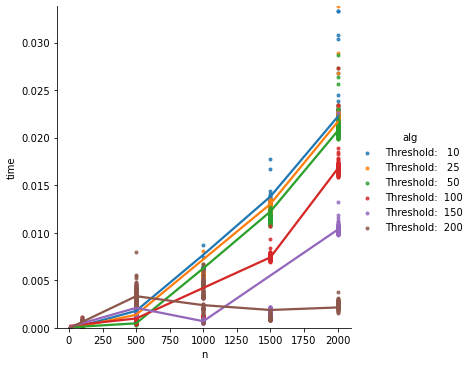

In [377]:
g = sns.lmplot(x = 'n', y = 'time', hue = 'alg', lowess = True,
               x_jitter = 0.1, markers='.',
               data = time_measures6)
g.set(ylim = (0, max(time_measures6['time'])))

<AxesSubplot:xlabel='n', ylabel='time'>

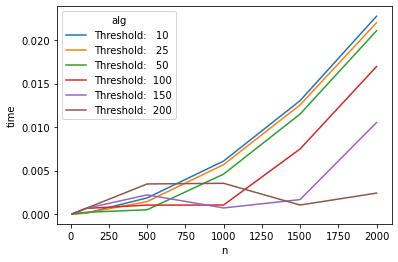

In [378]:
mean_time = time_measures6 \
    .groupby(['alg','n'], as_index = False) \
    .agg('mean') \
    .reset_index()
sns.lineplot(x = 'n', y = 'time', hue = 'alg', data = mean_time)

**Exercise:** Experiment with choices of threshold and find the best you can. Doing something like this is called *algorithmic engineering*. It is not about designing new algorithms but about finding optimal implementations by mixing them and by choosing good parameters.

The optimal threshold really depends on the length of the list. We can see that a threshold of 50 is optimal for n<=500, a threshold of 100 is optimal for 500<n<1000, a threshold of 150 for 1000 < n < 1500, and for n>1500 the optimal threshold is 200, this probably keeps changing as the size of the data increases.  

All the experiments have started with random lists. The results are potentially misleading if the list is already mostly sorted. You can use the function below to create almost sorted lists.

In [372]:
from random import sample
def almost_sorted(n, fraction_moved = 0.2):
    m = int(fraction_moved * n)
    x = list(range(n))
    idx1, idx2 = sample(range(n), m), sample(range(n), m)
    for i,j in zip(idx1, idx2):
            x[i], x[j] = x[j], x[i]
    return x

In [366]:
def time_algorithms_almost_sorted(ns, sort_algs):
    """
    Run each sort-algorithm implemented in functions and
    provided in `sort_algs` on random lists of length
    n for each n in `ns`.
    
    Returns a Pandas DataFrame that we can use for plotting
    or extracting summary data.
    """
    algs, ns_, times = [], [], []
    for n in ns:
        x = almost_sorted(n)
        for alg in sort_algs:
            x_copy = x[:]
            start = timer()
            alg(x_copy)
            end = timer()
            
            algs.append(alg.__name__)
            ns_.append(n)
            times.append(end - start)
            #print(alg,n,x)
            assert sorted(x) == x_copy
    
    return pd.DataFrame({'alg': algs, 'n': ns_, 'time': times})

In [379]:
small_thresholds = [1, 10, 25, 50]
large_thresholds = [100, 150, 200]
thresholds2 = small_thresholds + large_thresholds
no_reps = 100 # more repetitions to get better mean estimate
few_ns = [] 
for n in [10, 100, 500, 1000, 1500, 2000]:
    few_ns.extend([n] * no_reps)
hybrid_algs2 = [make_hybrid(th) for th in thresholds2]
time_measures6 = time_algorithms_almost_sorted(few_ns, hybrid_algs2)

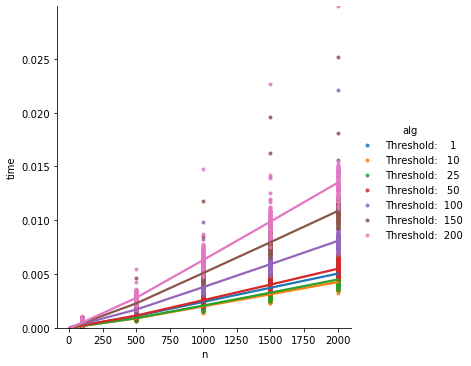

In [380]:
g = sns.lmplot(x = 'n', y = 'time', hue = 'alg', lowess = True,
               x_jitter = 0.1, markers='.',
               data = time_measures6)
g.set(ylim = (0, max(time_measures6['time'])))

<AxesSubplot:xlabel='n', ylabel='time'>

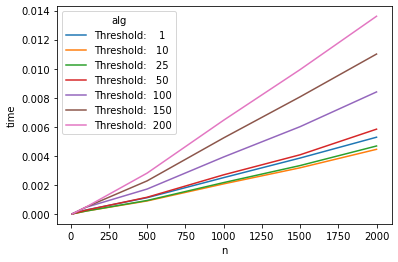

In [381]:
mean_time = time_measures6 \
    .groupby(['alg','n'], as_index = False) \
    .agg('mean') \
    .reset_index()
sns.lineplot(x = 'n', y = 'time', hue = 'alg', data = mean_time)

In [364]:
print(almost_sorted(10))
print(almost_sorted(10))
print(almost_sorted(10, 0.9))



[0, 3, 2, 1, 4, 5, 6, 7, 8, 9]
[0, 7, 2, 3, 4, 5, 6, 1, 8, 9]
[8, 1, 5, 3, 9, 2, 6, 7, 0, 4]


**Exercise:** Experiment with almost sorted lists and compare with the results for random lists.

To experiment with this we created a "new" time_algorithms, that uses the almost_sorted function to create its list, you can run this above. In this case it seems that the dependency on the insertion sort is reduced as speed increases as we reduce the threshold. Where with completely random lists we see that higher thresholds are more efficient at high n's. We tried to completely remove the insertion sort, by putting the threshold at 1, but this, unsurprisingly, yielded a slower time than the threshold = 10, because insertion sort sorts short lists fast like the devil.